In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('SampleData.csv')
data.head(3)

,Location,Role,VendorID,InvoiceValue,Resource,StartTimestamp,EndTimestamp,CaseId,ActivityName
0,"San Diego, USA",Invoice Processor,Vendor2,729.27,Casey,28/07/2022 9:23,28/07/2022 17:59,0,Invoice Entry
1,"San Diego, USA",Invoice Processor,Vendor2,729.27,Casey,28/07/2022 17:59,29/07/2022 0:43,0,Check Customer Payment
2,"San Diego, USA",Invoice Processor,Vendor2,729.27,Casey,29/07/2022 9:43,29/07/2022 15:04,0,Credit Memo Entry


### Clean Log

In [3]:
def clean_dataset (data, CaseID= 'caseid_column', Activity= 'activity_column' , StartTimeStamp= 'start_column' , EndTimeStamp= 'end_column'):
    # this function is to change the type of each log column to the right python format
    
    # Create a dictionary to map old column names to new column names
    rename_dict = {CaseID: 'CaseID', Activity: 'Activity', StartTimeStamp: 'StartTimeStamp', EndTimeStamp: 'EndTimeStamp' }
    
    # Use the rename method to rename the columns in the DataFrame
    data = data.rename(columns=rename_dict)
    
    # fix columns data types in python
    # Convert CaseId column to string
    data['CaseID'] = data['CaseID'].astype('str')
    
    # convert datetime column and get the dd-mm right
    data['StartTimeStamp'] = pd.to_datetime(data['StartTimeStamp'], dayfirst=True)
    data['EndTimeStamp'] = pd.to_datetime(data['EndTimeStamp'], dayfirst=True)
    
    
    return data

# link key log columns to organise dataset
data = clean_dataset(data, 
                     CaseID= "CaseId", 
                     Activity = 'ActivityName', 
                     StartTimeStamp= 'StartTimestamp',
                     EndTimeStamp= 'EndTimestamp' 
                    )

In [4]:
# Define the desired time to count the wip at
desired_time = '15:00:00'

In [5]:
# Create unduplicated list of all days at the desired count time
all_days = pd.to_datetime(data['StartTimeStamp'].dt.date.astype(str) + ' ' + desired_time).drop_duplicates()
all_days = all_days.sort_values()

In [6]:
# Count wip for all eventlog days at the 
rows = []
for day in all_days:
    count_wip = ((data['StartTimeStamp'] < day) & (data['EndTimeStamp'] > day)  ).sum()
    
    rows.append({'day': day, 'total_wip':count_wip })
    
wip_output = pd.DataFrame(rows)

In [7]:
wip_output.head(3)

,day,total_wip
0,2022-07-14 15:00:00,5
1,2022-07-15 15:00:00,11
2,2022-07-18 15:00:00,11


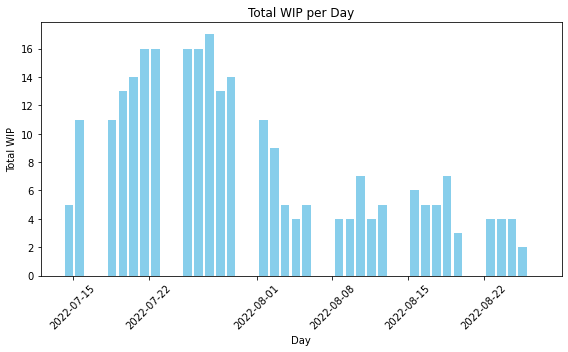

In [8]:
# plot the outcome
plt.figure(figsize=(8, 5))
plt.bar(wip_output['day'], wip_output['total_wip'], color='skyblue')
plt.xlabel('Day')
plt.ylabel('Total WIP')
plt.title('Total WIP per Day')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show plot
plt.show()

## Take wip per activity

In [9]:
all_activities = data['Activity'].drop_duplicates()

In [10]:
# Count wip for every activity in all eventlog days at the desired time 
rows = []

for day in all_days:
    for activity in all_activities:
        count_wip = ((data['Activity']==activity ) & (data['StartTimeStamp'] < day) & (data['EndTimeStamp'] > day)  ).sum()
    
        rows.append({'day': day, 'Activity': activity  ,'total_wip':count_wip })

wip_output_perActivity = pd.DataFrame(rows)

In [11]:
wip_output_perActivity.head(3)

,day,Activity,total_wip
0,2022-07-14 15:00:00,Invoice Entry,1
1,2022-07-14 15:00:00,Check Customer Payment,0
2,2022-07-14 15:00:00,Credit Memo Entry,1


In [12]:
# wip_output[wip_output['Activity'] == 'Invoice Entry' ]

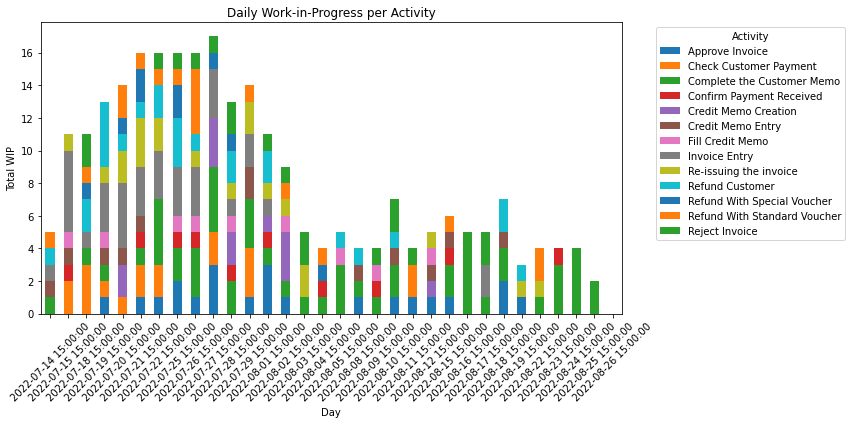

In [13]:
# Group by day and activity, summing the total_wip
grouped = wip_output_perActivity.groupby(['day', 'Activity'])['total_wip'].sum().reset_index()

# Pivot the table to have activities as columns and days as rows
pivot_table = grouped.pivot(index='day', columns='Activity', values='total_wip').fillna(0)

# Plotting the data
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Daily Work-in-Progress per Activity')
plt.xlabel('Day')
plt.ylabel('Total WIP')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()